In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import svm, ensemble
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.multiclass
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled

import warnings
warnings.filterwarnings('ignore')

dataset = 'enron'

In [2]:
edges = []
with open(f"data/{dataset}.hf", "r") as f:
    for line in f:
        edges.append(line.replace('\n', '').split(' '))
edges[-1]

['12', '38']

In [5]:
G = nx.Graph()
G.add_edges_from(edges)

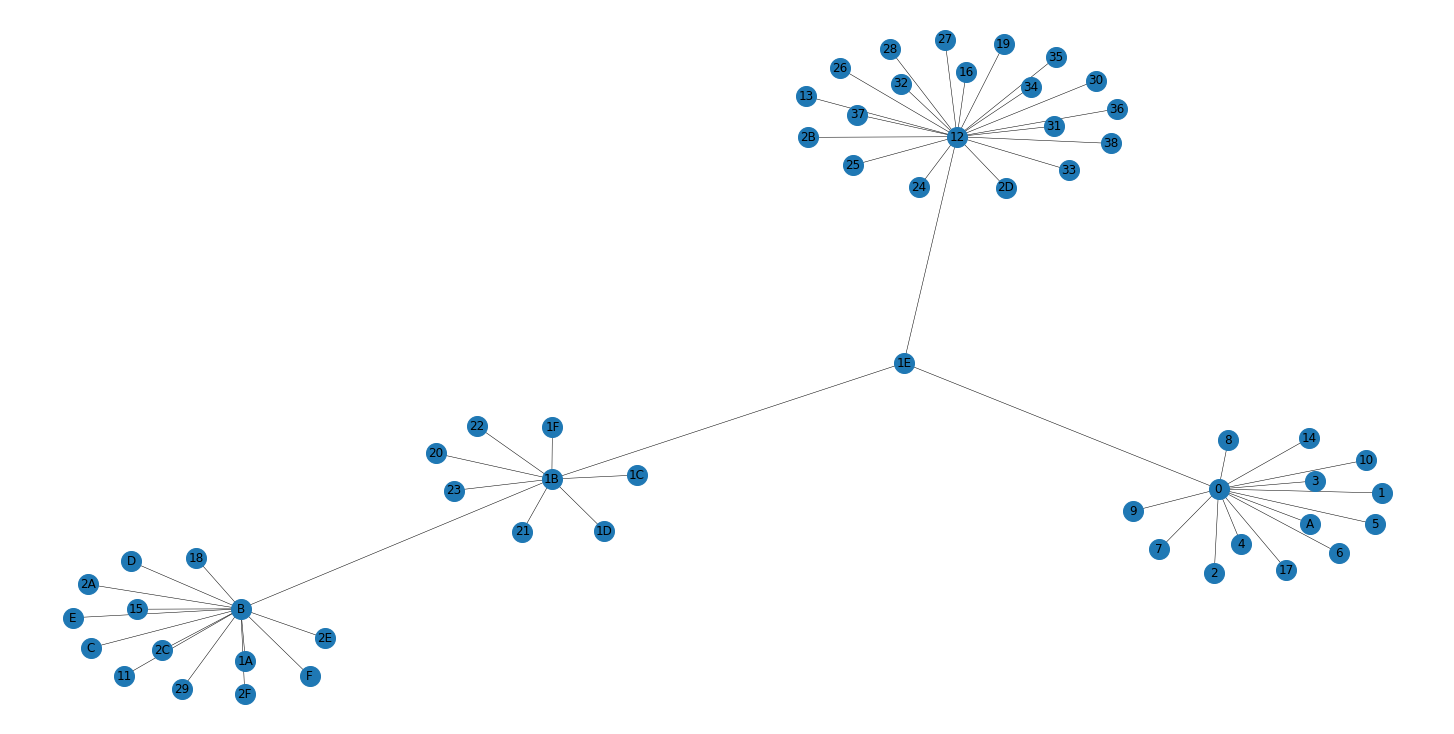

In [4]:
plt.figure(figsize=(20,10))
nx.draw(G, node_size=400, width=0.5, with_labels = True)

In [3]:
diG = nx.DiGraph()
diG.add_edges_from(edges)

def get_children(node):
    res = []
    for c in diG.edges(node):
        res.append(c[1])
    return res

hierarchy ={
    ROOT: get_children('1E'),
    '2': get_children('12'),
    '0': get_children('0'),
    '1B': get_children('1B'),
    'B': get_children('B'),
}

hierarchy

{'<ROOT>': ['1B', '0', '12'],
 '2': ['13',
  '16',
  '19',
  '24',
  '25',
  '26',
  '27',
  '28',
  '2B',
  '2D',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38'],
 '0': ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', '10', '14', '17'],
 '1B': ['1C', '1D', '1F', '20', '21', '22', '23', 'B'],
 'B': ['C',
  'D',
  'E',
  'F',
  '11',
  '15',
  '18',
  '1A',
  '29',
  '2A',
  '2C',
  '2E',
  '2F']}

In [4]:
def save_data(path):
    df = pd.DataFrame()
    with open(path, "r") as f:
        for line in f:
            row = {}
            values = line.replace('\n', '').split(' ')
            row['labels'] = values[0]
            values_string = ','.join(values[1:])
            values_string = f'row.update({{{values_string}}})'
            exec(values_string)
            df = df.append(row, ignore_index=True)
    df.to_csv(path + ".csv")

In [7]:
save_data(f"data/{dataset}_test")
save_data(f"data/{dataset}_train")

KeyboardInterrupt: 

In [5]:
df_test = pd.read_csv(f"data/{dataset}_test.csv", index_col=0)
df_train = pd.read_csv(f"data/{dataset}_train.csv", index_col=0)

In [6]:
if len(df_train.columns) != len(df_test.columns):
    for i in df_train.columns:
        if i not in list(df_test.columns):
            df_train = df_train.drop([i], axis=1)
len(df_train.columns) == len(df_test.columns)

True

In [7]:
df_train.groupby('labels').size()

labels
11               6
11,17            1
11,1F            1
11,1F,9          1
11,1F,9,16       1
                ..
F,C,8,9,2B       1
F,D,9            2
F,E,21,8,9,2B    1
F,E,8,9          1
F,E,8,9,17,2B    1
Length: 442, dtype: int64

In [7]:
# lables = {}
# for index, lable in enumerate(df_test['labels'].unique()):
#     lables[lable] = index
# lables

# for k, v in lables.items():
#     df_test.loc[df_test['labels'] == k] = v
#     df_train.loc[df_train['labels'] == k] = v

# Hierarchical methods

In [8]:
x_test = df_test.drop(columns=['labels'])
y_test = df_test['labels']

x_train = df_train.drop(columns=['labels'])
y_train = df_train['labels']

base_estimator = make_pipeline(
    TruncatedSVD(n_components=100),
    svm.SVC(
        gamma=0.001,
        kernel="rbf",
        probability=True
    ),
)
temp_lcpn = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=hierarchy,
    algorithm='lcpn'
)
temp_lcpn.fit(x_train, y_train)
graph = temp_lcpn.graph_

_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 0
_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 2


# Flat classification

In [20]:
def flat(train, test, classifier, hierarchy, n_components, graph, n_repeat=5):
    x_test = test.drop(columns=['labels'])
    y_test = test['labels'].apply(lambda x: x.split(','))

    x_train = train.drop(columns=['labels'])
    y_train = train['labels'].apply(lambda x: x.split(','))

    binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    y_train = binarizer.fit_transform(y_train)

    fin_res = []

    for _ in range(n_repeat):
        estimator = make_pipeline(
            TruncatedSVD(n_components=n_components),
            MultiOutputClassifier(classifier, n_jobs=-1)
        )

        estimator.fit(x_train, y_train)
        y_pred = estimator.predict(x_test)

        y_pred = binarizer.inverse_transform(y_pred)

        with multi_labeled(y_test, y_pred, graph) as (y_test_, y_pred_, graph_):
            h_fbeta = h_fbeta_score(
                y_test_,
                y_pred_,
                graph_,
            )
            fin_res.append(h_fbeta)

    return np.mean(fin_res)

In [21]:
flat(df_train, df_test, MLPClassifier(), hierarchy, 1, graph)

0.42665134793811055

## LCN

In [27]:
def lcn(train, test, classifier, hierarchy, n_components, graph, n_repeat=5):
    x_test = test.drop(columns=['labels'])
    y_test = test['labels'].apply(lambda x: x.split(','))

    x_train = train.drop(columns=['labels'])
    y_train = train['labels'].apply(lambda x: x.split(','))

    binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    y_train = binarizer.fit_transform(y_train)

    fin_res = []

    for _ in range(n_repeat):
        estimator = make_pipeline(
            TruncatedSVD(n_components=n_components),
            classifier
        )

        # h_classifier = HierarchicalClassifier(
        #     base_estimator=estimator,
        #     class_hierarchy=hierarchy,
        #     algorithm='lcn',
        #     mlb=binarizer
        # )

        h_classifier = sklearn.multiclass.OneVsRestClassifier(estimator=estimator)

        h_classifier.fit(x_train, y_train)
        y_pred = h_classifier.predict(x_test)

        y_pred = binarizer.inverse_transform(y_pred)

        with multi_labeled(y_test, y_pred, graph) as (y_test_, y_pred_, graph_):
            h_fbeta = h_fbeta_score(
                y_test_,
                y_pred_,
                graph_,
            )
        fin_res.append(h_fbeta)

    return np.mean(fin_res)

In [28]:
lcn(df_train, df_test, MLPClassifier(), hierarchy, 1, graph)

0.4251938323393361

## LCPN

In [11]:
def get_df4lcpn(x, y, hierarchy):
    count = 0
    fin_r = {}

    for k, v in hierarchy.items():
        c = 0
        if k != ROOT:
            result = {}
            df = pd.DataFrame()
            clsss = []
            lables = []
            for i, row in y.items():
                temp = np.isin(np.array(v), np.array(row))
                if any(temp == True):
                    df = df.append(x.loc[[i]])
                    lables.append(temp.astype(int).copy())
                    clsss.append(row.copy())
            result['key'] = v.copy()
            result['df'] = df
            result['lb'] = lables.copy()
            result['cl'] = clsss.copy()
            fin_r[count] = result
            count += 1
    return fin_r

In [12]:
def lcpn(train, test, classifier, hierarchy, n_components, graph, n_repeat=5):
    x_test = df_test.drop(columns=['labels'])
    y_test = df_test['labels'].apply(lambda x: x.split(','))

    x_train = df_train.drop(columns=['labels'])
    y_train = df_train['labels'].apply(lambda x: x.split(','))

    test_lcpn = get_df4lcpn(x_test, y_test, hierarchy)
    train_lcpn = get_df4lcpn(x_train, y_train, hierarchy)

    fin_res = []

    for _ in range(n_repeat):
        for k, v in train_lcpn.items():
            x_train_lcpn = train_lcpn[k]['df']
            y_train_lcpn = train_lcpn[k]['lb']

            x_test_lcpn = test_lcpn[k]['df']
            y_test_lcpn = test_lcpn[k]['lb']

            estimator = make_pipeline(
                TruncatedSVD(n_components=n_components),
                MultiOutputClassifier(classifier, n_jobs=-1)
            )

            estimator.fit(x_train_lcpn, y_train_lcpn)
            y_pred_lcpn = estimator.predict(x_test_lcpn)

            y_pred_local = []
            for ypl in y_pred_lcpn: 
                temp = [e for i, e in enumerate(test_lcpn[k]['key']) if ypl[i] == 1]
                y_pred_local.append(temp)

            y_test_local = []
            for ytl in y_test_lcpn: 
                temp = [e for i, e in enumerate(test_lcpn[k]['key']) if ytl[i] == 1]
                y_test_local.append(temp)

            with multi_labeled(y_test_local, y_pred_local, graph) as (y_test_, y_pred_, graph_):
                h_fbeta = h_fbeta_score(
                    y_test_,
                    y_pred_,
                    graph_,
                )
                fin_res.append(h_fbeta)

    return np.mean(fin_res)

In [28]:
lcpn(df_train, df_test, RandomForestClassifier(), hierarchy, 1, graph)

0.6735809579139411

## LCL - per Level

In [13]:
def lcl(train, test, classifier, hierarchy, n_components, graph, n_repeat=5):
    x_test = df_test.drop(columns=['labels'])
    y_test = df_test['labels'].apply(lambda x: x.split(','))

    x_train = df_train.drop(columns=['labels'])
    y_train = df_train['labels'].apply(lambda x: x.split(','))

    lvl1, lvl2 = [], []
    for k, v in hierarchy.items():
        if k != ROOT:
            if k in ['1B', '0', '2']:
                lvl1 += v
            else:
                lvl2 += v

    lcl_hierarchy = {0: lvl1, 1: lvl2}
        
    test_lcpn = get_df4lcpn(x_test, y_test, lcl_hierarchy)
    train_lcpn = get_df4lcpn(x_train, y_train, lcl_hierarchy)

    results = []

    for k, v in train_lcpn.items():
        x_train_lcpn = train_lcpn[k]['df']
        y_train_lcpn = train_lcpn[k]['lb']

        x_test_lcpn = test_lcpn[k]['df']
        y_test_lcpn = test_lcpn[k]['lb']

        estimator = make_pipeline(
            TruncatedSVD(n_components=n_components),
            MultiOutputClassifier(classifier, n_jobs=-1)
        )

        estimator.fit(x_train_lcpn, y_train_lcpn)
        y_pred_lcpn = estimator.predict(x_test_lcpn)

        y_pred_local = []
        for ypl in y_pred_lcpn: 
            temp = [e for i, e in enumerate(test_lcpn[k]['key']) if ypl[i] == 1]
            y_pred_local.append(temp)

        y_test_local = []
        for ytl in y_test_lcpn: 
            temp = [e for i, e in enumerate(test_lcpn[k]['key']) if ytl[i] == 1]
            y_test_local.append(temp)

        with multi_labeled(y_test_local, y_pred_local, graph) as (y_test_, y_pred_, graph_):
            h_fbeta = h_fbeta_score(
                y_test_,
                y_pred_,
                graph_,
            )
            results.append(h_fbeta)

    return np.mean(results)

In [272]:
lcl(df_train, df_test, MLPClassifier(), hierarchy, 1, graph)

0.3472993732333784

# Experiments

In [48]:
models = {
    "Random Forest": RandomForestClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "MLP": MLPClassifier()
}
func = {
    # 'LCPN': lcpn,
    # 'Flat': flat,
    'LCL': lcl,
    'LCN': lcn
}

In [49]:
df_res = pd.DataFrame()
for k_f, v_f in func.items():
    for k_m, v_m in models.items():
        start = time.time()
        fsc = v_f(df_train, df_test, v_m, hierarchy, 1, graph)
        t = round(time.time() - start, 2)

        print(k_m, k_f, t, fsc)

        df_res = df_res.append({
            'model': k_m,
            'func': k_f,
            'total_time': t,
            'h_fbeta': fsc
            }, ignore_index=True)

Random Forest LCL 7.74 0.6015313971196438
KNeighbors LCL 3.93 0.4416450743140618
MLP LCL 9.41 0.3387312174000917
Random Forest LCN 62.25 0.5439642285213004
KNeighbors LCN 12.74 0.4436493738819321
MLP LCN 131.95 0.42615814569026683


In [53]:
df_res

,func,h_fbeta,model,total_time
0,LCL,0.601531,Random Forest,7.74
1,LCL,0.441645,KNeighbors,3.93
2,LCL,0.338731,MLP,9.41
3,LCN,0.543964,Random Forest,62.25
4,LCN,0.443649,KNeighbors,12.74
5,LCN,0.426158,MLP,131.95


In [46]:
df_fin = df_res.copy()

In [51]:
df_fin = pd.concat([df_fin, df_res.copy()])

In [55]:
df_fin.to_csv("results.csv", index=False)

In [56]:
results = pd.read_csv("results.csv")
results

,func,h_fbeta,model,total_time
0,LCPN,0.673893,Random Forest,24.83
1,LCPN,0.516192,KNeighbors,9.46
2,LCPN,0.470589,MLP,32.65
3,Flat,0.543750,Random Forest,26.06
4,Flat,0.443649,KNeighbors,2.91
5,Flat,0.424682,MLP,33.15
6,LCL,0.601531,Random Forest,7.74
7,LCL,0.441645,KNeighbors,3.93
8,LCL,0.338731,MLP,9.41
9,LCN,0.543964,Random Forest,62.25


In [66]:
results[(results['model'] == 'Random Forest')].h_fbeta.tolist()

[0.6738928409582726,
 0.5437499866308924,
 0.6015313971196438,
 0.5439642285213004]

In [81]:
def draw(title, ylabel, x_labels, y_data, yticks):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.title(title)
    plt.ylabel(ylabel)
    ax.bar(x_labels,y_data)
    ax.set_yticks(yticks)
    plt.show()

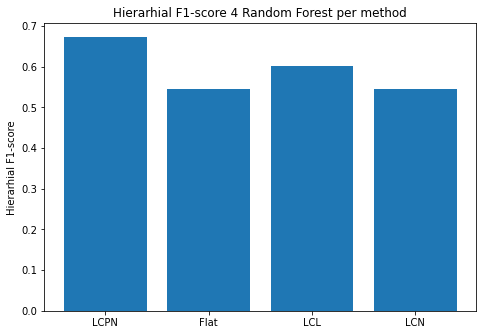

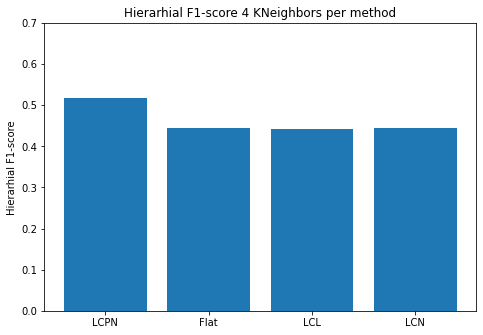

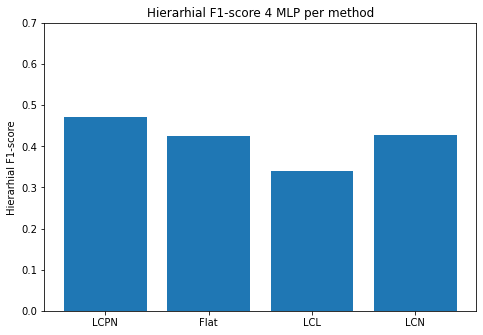

In [105]:
for m in results.model.unique():
    draw(f"Hierarhial F1-score 4 {m} per method", "Hierarhial F1-score", results.func.unique(), results[(results['model'] == m)].h_fbeta.tolist(), np.arange(0, 0.8, 0.1))

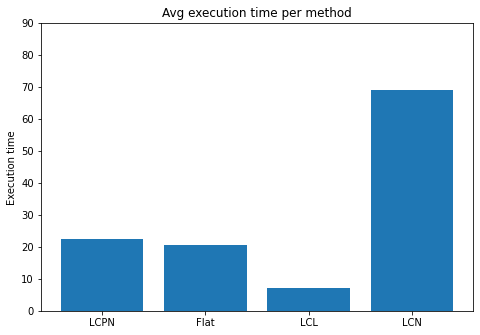

In [103]:
mean_time = []
for f in results.func.unique():
    mean_time.append(results[(results['func'] == f)].total_time.mean())

mean_time

draw(f"Avg execution time per method", "Execution time", results.func.unique(), mean_time, np.arange(0, 100, 10))

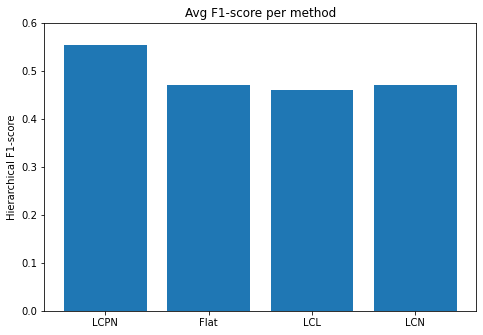

In [106]:
mean_fsc = []
for f in results.func.unique():
    mean_fsc.append(results[(results['func'] == f)].h_fbeta.mean())

draw(f"Avg F1-score per method", "Hierarchical F1-score", results.func.unique(), mean_fsc, np.arange(0, 0.7, 0.1))

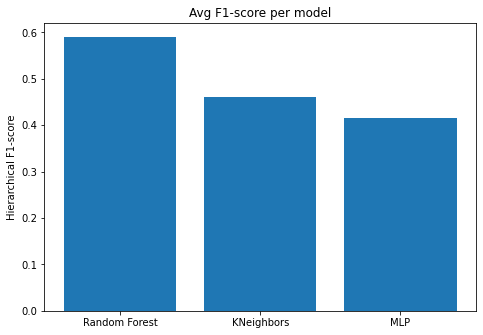

In [107]:
mean_fsc = []
for m in results.model.unique():
    mean_fsc.append(results[(results['model'] == m)].h_fbeta.mean())

draw(f"Avg F1-score per model", "Hierarchical F1-score", results.model.unique(), mean_fsc, np.arange(0, 0.7, 0.1))

In [110]:
results[results['func'] == 'Flat']

,func,h_fbeta,model,total_time
3,Flat,0.543750,Random Forest,26.06
4,Flat,0.443649,KNeighbors,2.91
5,Flat,0.424682,MLP,33.15


# Wnioski

## Flat
Pros:
* jeden klasyfikator
* intuicyjna architektura
* dla zbioru danych *enron* osiągnięto **średnie wyniki**. W porównaniu do innych metod: avg execution time ~20sek, avg hfsc ~0.46

Cons:
* traci się informacje powiązań hierarchicznych parent-child
* operuje liściami. To znaczy, że nie jest w stanie odnieść przykład do węzła rodzica, wyłącznie do zbioru dzieci

## LCN - local calssifier per node
Pros:
* dla każdego węzła uczymy binarny klasyfikator, 13 węzłów - 13 klasyfikatorów. Jest prosty do interpretaji wyników

Cons:
* w przypadku dużej liczby klas - wzrasta liczba klasyfikatorów. 100 klas - 100 klasyfikatorów
* problem niespójności
* Średnie wyniki: avg hfsc ~0.46, **Najdłuszy avg execution time = 70sek**

## LCL - local classifier per level
Pros:
* w przypdku wybranego zbioru - **najmniesza liczba klasyfikatorów - 2**
* łatwa implementacja
* **najszybszy avg execution time ~5sek**

Cons:
* **osiągnięto najgorsze wyniki avg hfsc ~0.46**
* problem niespójności
* z reguły im głębiej, tym więcej labeli do przypisania
* kompletna rezygnacja ze struktury parent-child

## LCPN - local classifier per parent node
Pros:
* w przypadku wybranego zbioru otrzymano **najlepsze wyniki: avg execution time = 22sek (średni wynik), avg hfsc ~0.56**
* łatwiesza implementacja w porównaniu do LCN. Mniej klasyfikatorów do wyuczenia.

Cons:
* problem niespójności
